In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Custom imports
import sys
sys.path.insert(0, "../")
from plots import interpolation_plot
from models.classifier import ChainedClassifier
from utils import load_model, class_sampler
from attacks import *
device = 'cuda' #'cpu'

def latent_interpolation_linear(source, target, no_steps=18):
    corners = torch.stack((source, target)).permute(1, 2, 3, 0).squeeze(2)
    grid_noise = F.interpolate(corners, size=no_steps, mode='linear', align_corners=True)
    grid_noise = grid_noise.permute(2, 0, 1).unsqueeze(3)
    return grid_noise

def latent_interpolation_bisection(classifier, source, target, source_label, no_steps=18):
    data = []
    for i in np.linspace(1, 0, no_steps):
            function = InterpolationValue(classifier, source, target, source_label)
            c = bisection(function, i, a=0, b=1, threshold=0.001)
            data.append(function.evaluate(c))
    return torch.cat(data)

torch.manual_seed(0)
classifier = load_model(r'..\runs\mnist\cls-mnist', device=device)
generator = load_model(r'..\runs\mnist\ali-mnist', device=device)
combined = ChainedClassifier(generator, classifier)

# Store samples for each class to dict
d = {c: class_sampler(classifier, generator, c, samples=100, threshold=0.99, device=device) for c in range(10)}

# Linear interpolation

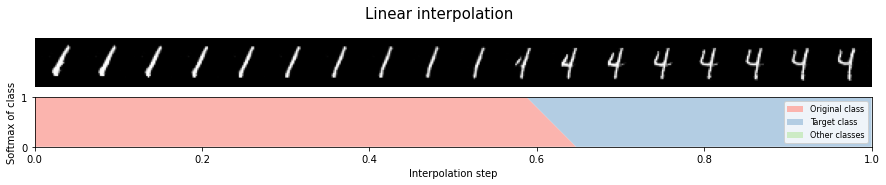

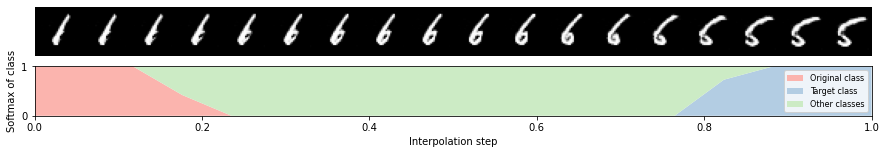

In [2]:
plot_params = {
    'ylabel': 'Softmax of class',
    'xlabel': 'Interpolation step',
    'xticks': [f"{i:.1f}" for i in np.linspace(0, 1, 6)],
    'legend': ['Original class', 'Target class', 'Other classes']
}

# Effect of interpolation on class predictions
source_label = 1
target_label = 4
z = latent_interpolation_linear(d[source_label][0], d[target_label][0])
fig1 = interpolation_plot(generator.decode(z), classifier, source_label, target_label, **plot_params)
fig1.suptitle('Linear interpolation', size=15, y=1.1)
fig1.savefig('figures/int_linear_effect1.png', bbox_inches='tight')

source_label = 1
target_label = 5
z = latent_interpolation_linear(d[source_label][0], d[target_label][4])
fig2 = interpolation_plot(generator.decode(z), classifier, source_label, target_label, **plot_params)
fig2.savefig('figures/int_linear_effect2.png', bbox_inches='tight')


# Bisection

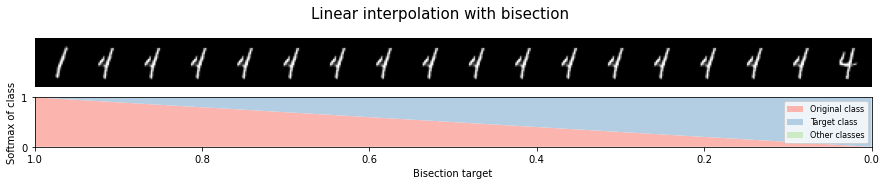

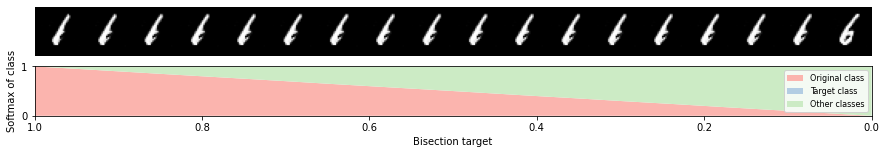

In [3]:
plot_params = {
    'ylabel': 'Softmax of class',
    'xlabel': 'Bisection target',
    'xticks': [f"{i:.1f}" for i in np.linspace(1, 0, 6)],
    'legend': ['Original class', 'Target class', 'Other classes']
}

source_label = 1
target_label = 4
z = latent_interpolation_bisection(combined, d[source_label][0], d[target_label][0], source_label)
fig1 = interpolation_plot(generator.decode(z), classifier, source_label, target_label, **plot_params)
fig1.suptitle('Linear interpolation with bisection', size=15, y=1.1)
fig1.savefig('figures/int_bisection_effect1.png', bbox_inches='tight')

source_label = 1
target_label = 5
z = latent_interpolation_bisection(combined, d[source_label][0], d[target_label][4], source_label)
fig2 = interpolation_plot(generator.decode(z), classifier, source_label, target_label, **plot_params)
fig2.savefig('figures/int_bisection_effect2.png', bbox_inches='tight')